## Algorithm Description: Highpass Filter

### Motivation & Goal of Algorithm
###### What problem does the data have that requires this algorithm to fix it?

The EEG data we are using appears to have low frequency, high energy noise. This noise manifests itself in slow, high magnitude drifts in the attained values of channels. We visualize this below.

##### Loading the data...

In [86]:
%matplotlib inline
import cPickle as pkl
base = '../../data/'
path = 'bids_raw/sub-0001/ses-01/eeg/'
file_name = 'sub-0001_ses-01.pkl'
full_path = base + path + file_name
with open(full_path, 'rb') as f:
    D = pkl.load(f)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from panda.methods import viz as viz
from panda import config
p_global = config.params['p_global']
eog_chans = np.array(p_global['eog_chans']) - 1
eeg_chans = np.setdiff1d(np.arange(128), eog_chans)
p_global.update({'eog_chans': eog_chans,
                'eeg_chans': eeg_chans})

p_global['plotting']['notebook'] = True

# Complete all the previous pipeline steps
from panda.methods.misc import setup
(D, p_local) = setup(D, {}, p_global)

#### Visualizing the data...
##### Heatmaps
The heatmaps shown show the slow high magnitude drifts we mentioned previously.

In [ ]:
print "EEG Data Heatmap"
viz.heatmap(D, {'eog_in': True}, p_global)

##### Frequency Domain
Plotting one of the channels in the frequency domain shows more drastically the problem: There is high energy noise at the low frequency bands.

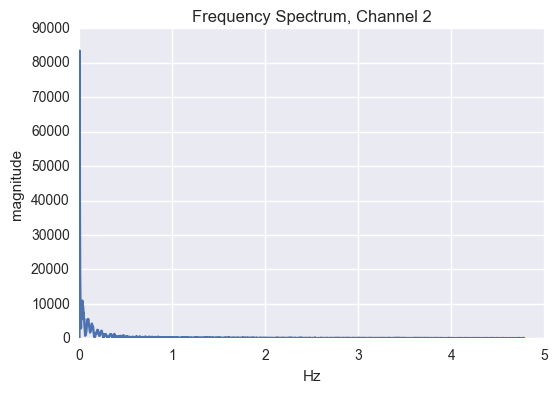

In [28]:
F_s = 500 # sampling frequency
dt = 1./F_s
sample_points = np.arange(D.shape[1]) * dt
signal = D[2, :]
ft = np.fft.fft(signal) * dt
ft = ft[: len(sample_points)/2]
freq = np.fft.fftfreq(len(sample_points), dt)
freq = freq[:len(sample_points)/2]
plt.plot(freq[:2000] , np.abs(ft)[:2000])
plt.title('Frequency Spectrum, Channel ' + str(2))
plt.xlabel("Hz")
plt.ylabel("magnitude")
plt.show()

The slow drifts seen here can be removed by filtering out low frequency components. To this end, we apply a high pass filter at 1 Hz to each channel in the data matrix.

### Setting

Consider multivatiate timeseries data with $C$ channels and $T$ timesteps. Suppose that each channel in the data has high energy noise at low frequency bands, e.g. $M = \mathbb{R}^{T \times C}$ has low frequency noise in each row. We would like to apply a high pass filter to each for of this matrix.

We use a butterworth filter for this purpose.

#### Algorithm Pseudo Code
On input $M \in \mathbb{R}^{C \times T}$, $o$ a filter order, and $f$ a high pass frequency:
1. Create a butterworth filter $B$ to high pass filter at $f Hz$ with order $o$.
2. For each $r$ row of the matrix $M$:
  * Apply $B$ to row $r$
3. Return $M$.

#### Real Code
The code for this function is located in our [`panda.denoise`](https://github.com/rmarren1/panda/blob/master/panda/methods/denoise.py) package in the `highpass` function.

### Simulations

#### Qualatative
##### Generating Sample Data

We start with a signal composed of some random sine wave compositions. The frequencies of such sine waves are randomly chosen.

We show one example of a randomly constructed sine wave composition, first in decomposed form, and then in its normal form.

Finally, we show this signal in the frequency domain.

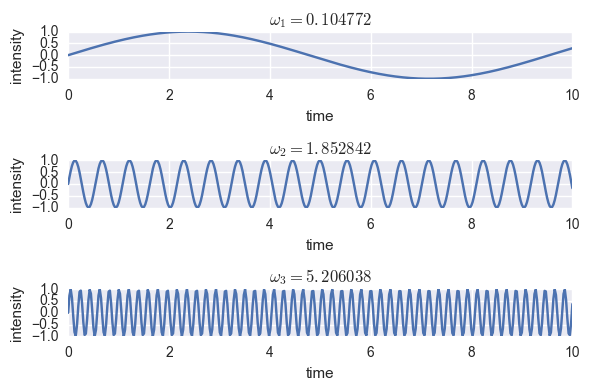

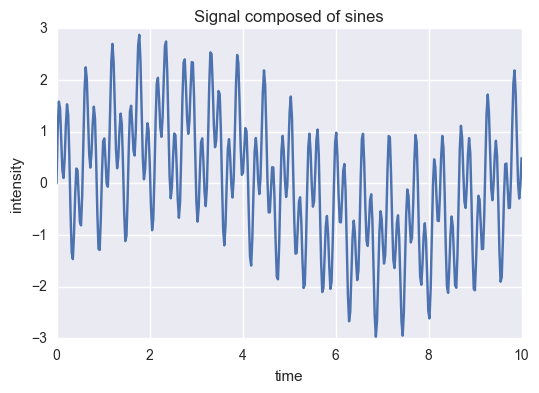

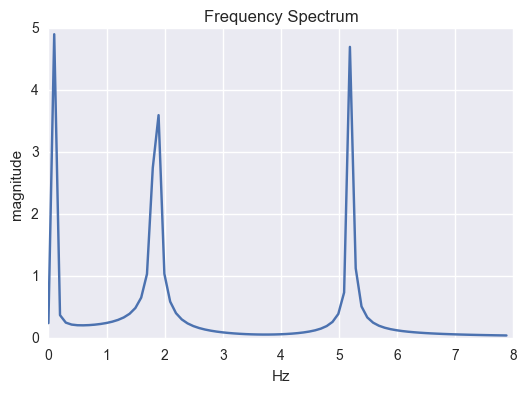

In [67]:
T = 10 # Signal lasts 10 seconds
Fs = 40 # We sample the signal at 40 Hz
w1 = np.random.normal(.1, .005)
w2 = np.random.normal(2, .5)
w3 = np.random.normal(4, .8)
sample_points = np.linspace(0, T, T * Fs)
sines_w1 = np.sin(w1 * 2 * np.pi * sample_points)
sines_w2 = np.sin(w2 * 2 * np.pi * sample_points)
sines_w3 = np.sin(w3 * 2 * np.pi * sample_points)
plt.subplot(3, 1, 1)
# First separate
plt.plot(sample_points, sines_w1)
plt.xlabel("time")
plt.ylabel("intensity")
plt.title(r'$\omega_1 = %f$' % (w1))
plt.subplot(3, 1, 2)
# Second separate
plt.plot(sample_points, sines_w2)
plt.title(r'$\omega_2 = %f$' % (w2))
plt.xlabel("time")
plt.ylabel("intensity")
plt.subplot(3, 1, 3)
# Third Separate
plt.plot(sample_points, sines_w3)
plt.title(r'$\omega_3 = %f$' % (w3))
plt.xlabel("time")
plt.ylabel("intensity")
plt.tight_layout()
plt.show()
# Together
signal = sines_w1 + sines_w2 + sines_w3
plt.plot(sample_points, signal)
plt.title('Signal composed of sines')
plt.xlabel("time")
plt.ylabel("intensity")
plt.show()
# Frequency
dt = sample_points[1] - sample_points[0]
ft = np.fft.fft(signal) * dt
ft = ft[: len(sample_points)/2]
freq = np.fft.fftfreq(len(sample_points), dt)
freq = freq[:len(sample_points)/2]
plt.plot(freq[0:80] , np.abs(ft)[0:80])
plt.title('Frequency Spectrum')
plt.xlabel("Hz")
plt.ylabel("magnitude")
plt.show()

##### Applying method to sample data

In [116]:
from panda.methods.denoise import highpass
signal = np.array([signal])
settings = {
    'hpf': {
        'order': 1,
        'Fs': 500,
        'cutoff': 1
    }
}
(signal, _) = highpass(signal, {}, settings)

##### Plotting results

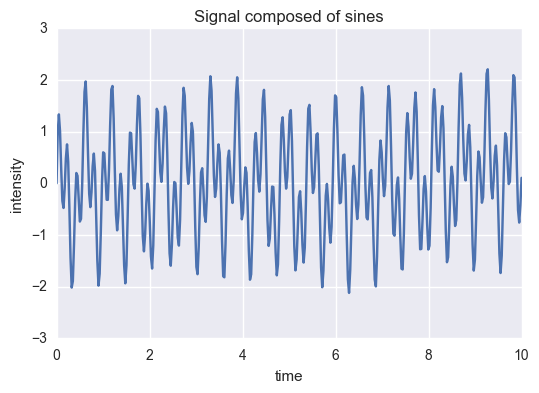

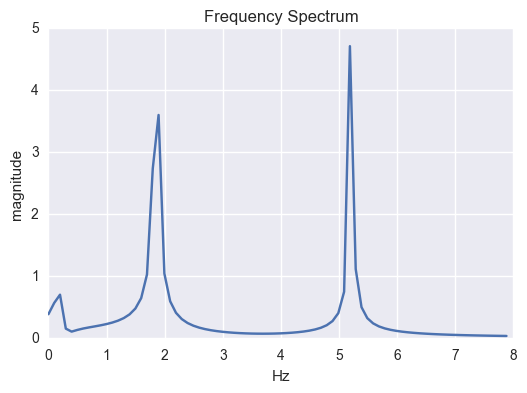

In [117]:
# Together
signal = signal[0, :]
plt.plot(sample_points, signal)
plt.title('Signal composed of sines')
plt.xlabel("time")
plt.ylabel("intensity")
plt.show()
# Frequency
dt = sample_points[1] - sample_points[0]
ft = np.fft.fft(signal) * dt
ft = ft[: len(sample_points)/2]
freq = np.fft.fftfreq(len(sample_points), dt)
freq = freq[:len(sample_points)/2]
plt.plot(freq[0:80] , np.abs(ft)[0:80])
plt.title('Frequency Spectrum')
plt.xlabel("Hz")
plt.ylabel("magnitude")
plt.show()

As we can see the results, the filter we constructed successfully lowered the low frequency components.

#### Quantitative
##### Generating Sample Data
We will use the same method of generating sample data as we did previously.

In [124]:
def sine_sample(T, Fs, musigs):
    sample_points = np.linspace(0, T, T * Fs)
    signals = []
    for mu, sig in musigs:
        w = np.random.normal(mu, sig)
        sines_w = np.sin(w * 2 * np.pi * sample_points)
        signals.append(sines_w)
    signal = signals[0]
    for sine_w in signals[1:]:
        signal = signal + sine_w
    return signal
musigs = [(.1, .1), (.2, .1), (.5, .1), (.1, .2), (4, .2), (.26, .3), (.76, 1), (5, 1), (12, 1)]
Fs = 40
T = 10
sample_signals = [sine_sample(T, Fs, musigs) for i in range(100)]

##### Run Numerical Experiment
Here, we ensure that the energy at frequencies below 1Hz is reduced by the signal.

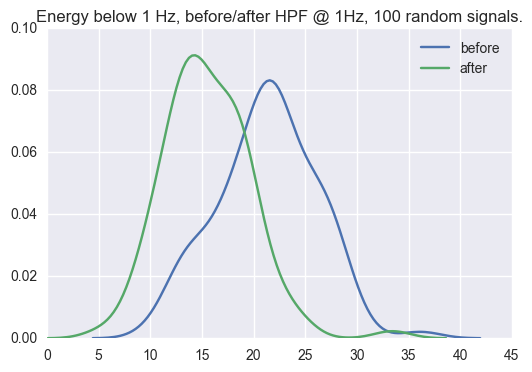

In [125]:
def eng_hz(signal, hz, dt):
    ft = np.fft.fft(signal) * dt
    ft = ft[: len(sample_points)/2]
    freq = np.fft.fftfreq(len(sample_points), dt)
    freq = freq[:len(sample_points)/2]
    return np.sum(np.abs(ft[freq < hz]))
before_dist = [eng_hz(sample_signals[i], .5, 1./40) for i in range(len(sample_signals))]
filtered = [highpass(np.array([sample_signals[i]]), {}, settings)[0][0] for i in range(len(sample_signals))]
after_dist = [eng_hz(filtered[i], .5, 1./40) for i in range(len(filtered))]
sns.distplot(before_dist, label='before', hist=False)
sns.distplot(after_dist, label='after', hist=False)
plt.title('Energy below 1 Hz, before/after HPF @ 1Hz, 100 random signals.')
plt.show()

These results show that the function behaved as expected: Energy at low frequency bands was heavily reduced.

### Application to Real Data

#### Running on real data

In [127]:
(D_hp, p_local) = highpass(D, {}, p_global)

#### Results
##### Heatmaps...

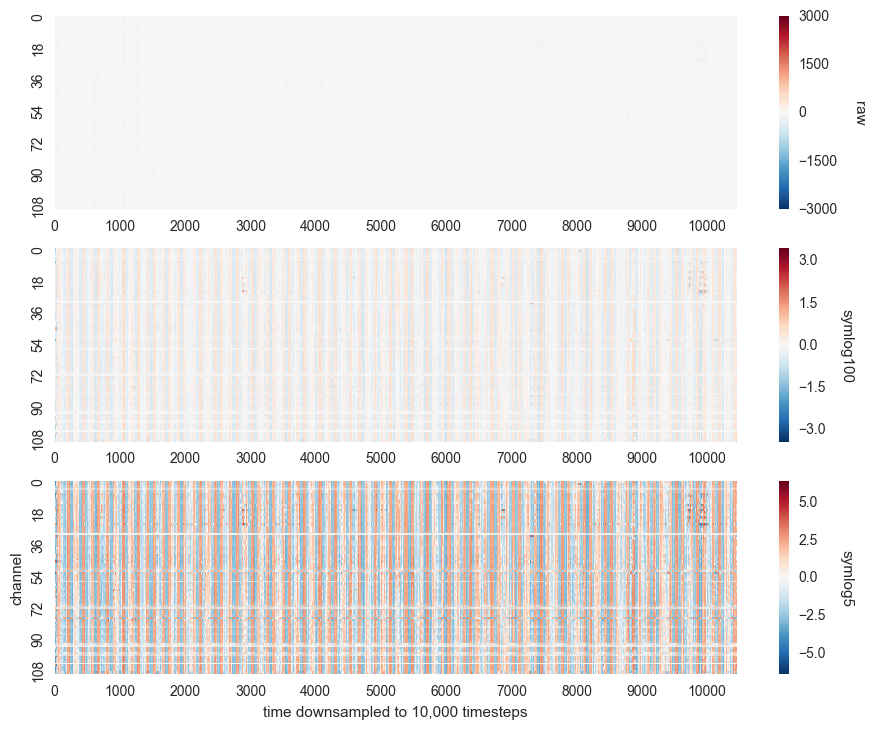

In [128]:
viz.heatmap(D_hp, {'eog_in': True}, p_global)

##### Frequency Domain

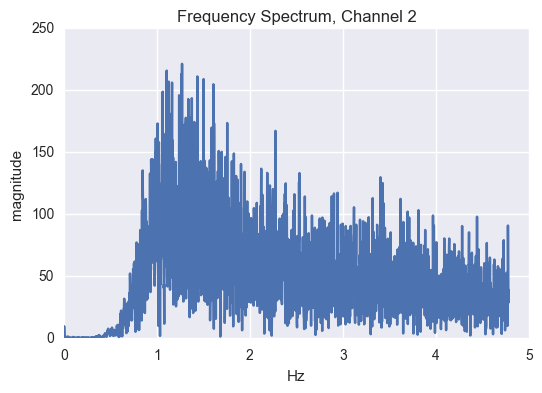

In [130]:
F_s = 500 # sampling frequency
dt = 1./F_s
sample_points = np.arange(D.shape[1]) * dt
signal = D_hp[2, :]
ft = np.fft.fft(signal) * dt
ft = ft[: len(sample_points)/2]
freq = np.fft.fftfreq(len(sample_points), dt)
freq = freq[:len(sample_points)/2]
plt.plot(freq[:2000] , np.abs(ft)[:2000])
plt.title('Frequency Spectrum, Channel ' + str(2))
plt.xlabel("Hz")
plt.ylabel("magnitude")
plt.show()

These results confer our predicted behavior of the algorithm and solve the problems which originally motivated it.
Now we show the residual of the high pass filtered data from the mean centered data.

#### Results...
Here are the discriminibility results after running this function on an entire dataset (after the preceding functions in the pipeline)...
![image](../results/bids_raw/disc-heat-_highpass.png)
And here are the distributions of the intra and inter subject distances.
![image](../results/bids_raw/dists-highpass.png)